# 🧬 NTv3 Multi-Scale Interpretation Pipeline

This notebook demonstrates how to use the NTv3 interpretation pipeline for multi-scale analysis of regulatory logic.

The pipeline abstracts away all underlying steps: inference, attention extraction, saliency computation, and visualization.

**Interpretability modalities:**
1. **Functional tracks** - Regulatory activity across thousands of assays
2. **Genome annotations** - Gene-structural and regulatory elements
3. **Attention maps** - Long-range information integration
4. **Saliency maps** - Gradient-based sequence attributions

For step-by-step explanations, see the [interpretation tutorial](https://huggingface.co/spaces/InstaDeepAI/ntv3/blob/main/notebooks_tutorials/03_model_interpretation.ipynb).

> 📝 **Note for Google Colab users:** Enable GPU for faster inference: Runtime → Change runtime type → GPU (T4 or better recommended)


## 0) 📦 Imports + Setup


In [ ]:
# Login to HuggingFace (required for gated models)
from huggingface_hub import login
login()

In [ ]:
# Install dependencies
!pip -q install "transformers>=4.55" "huggingface_hub>=0.23" safetensors torch pyfaidx requests seaborn matplotlib numpy seam-nn pyBigWig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.6/118.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.1/187.1 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 69.6 MB/s eta 0:00:00


In [ ]:
import sys
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import (
    pipeline,
    AutoConfig,
    AutoModel,
    AutoTokenizer,
    AutoModelForMaskedLM,
)

## 1) 📦 Configuration
> 💡 **Note:** For a T4 GPU (available for free in Google Colab), we recommend using an input sequence length of 32kb or shorter.


In [ ]:
# -----------------------------
# User Configuration
# -----------------------------
model_name = "InstaDeepAI/NTv3_650M_post"

# Genomic window (must be multiple of 128 due to model downsampling)
species = "human"
chrom = "chr11"
center_position = 5_269_945  # Center of region of interest (HBE1 locus)
sequence_length = 32_768

# Calculate start/end from center
start = center_position - sequence_length // 2
end = center_position + sequence_length // 2

# Track for saliency computation
saliency_track_id = "ENCSR000EFT"  # K562 GATA1 ChIP-seq

# Analysis parameters
token_resolution = 128  # bp per token

print(f"Model: {model_name}")
print(f"Region: {chrom}:{start:,}-{end:,} ({sequence_length:,} bp)")
print(f"Center: {center_position:,}")

print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")


Model: InstaDeepAI/NTv3_650M_post
Region: chr11:5,253,561-5,286,329 (32,768 bp)
Center: 5,269,945
Device: cuda


## 2) 🤖 Build Interpretation Pipeline

In [ ]:
ntv3_interpret = pipeline(
    "ntv3-interpret",
    model=model_name,
    trust_remote_code=True,
    device=0 if torch.cuda.is_available() else -1,
)

print(f"\n✅ Pipeline loaded")
print(f"   Elements: {len(ntv3_interpret.bed_element_names)}")


config.json:   0%|          | 0.00/339k [00:00<?, ?B/s]

configuration_ntv3_posttrained.py:   0%|          | 0.00/4.70k [00:00<?, ?B/s]

configuration_ntv3_pretrained.py:   0%|          | 0.00/8.09k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/ntv3_base_model:
- configuration_ntv3_pretrained.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/ntv3_base_model:
- configuration_ntv3_posttrained.py
- configuration_ntv3_pretrained.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


ntv3_interpret_pipeline.py:   0%|          | 0.00/61.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/NTv3_650M_post:
- ntv3_interpret_pipeline.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_ntv3_posttrained.py:   0%|          | 0.00/44.3k [00:00<?, ?B/s]

modeling_ntv3_pretrained.py:   0%|          | 0.00/35.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/ntv3_base_model:
- modeling_ntv3_pretrained.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/ntv3_base_model:
- modeling_ntv3_posttrained.py
- modeling_ntv3_pretrained.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/2.72G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

tokenization_ntv3.py:   0%|          | 0.00/7.85k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/InstaDeepAI/ntv3_base_model:
- tokenization_ntv3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/149 [00:00<?, ?B/s]

Device set to use cuda:0



✅ Pipeline loaded
   Elements: 21


## 3) ⚡ Run Interpretation Pipeline

Single call to get tracks, annotations, attention, and saliency.


Fetching sequence from UCSC API: hg38:chr11:5,253,561-5,286,329
Running on device: cuda:0
Computing saliency for track indices: [1643]
Saliency using center 50% of sequence: 16,384 bp (positions 8,192-24,576)


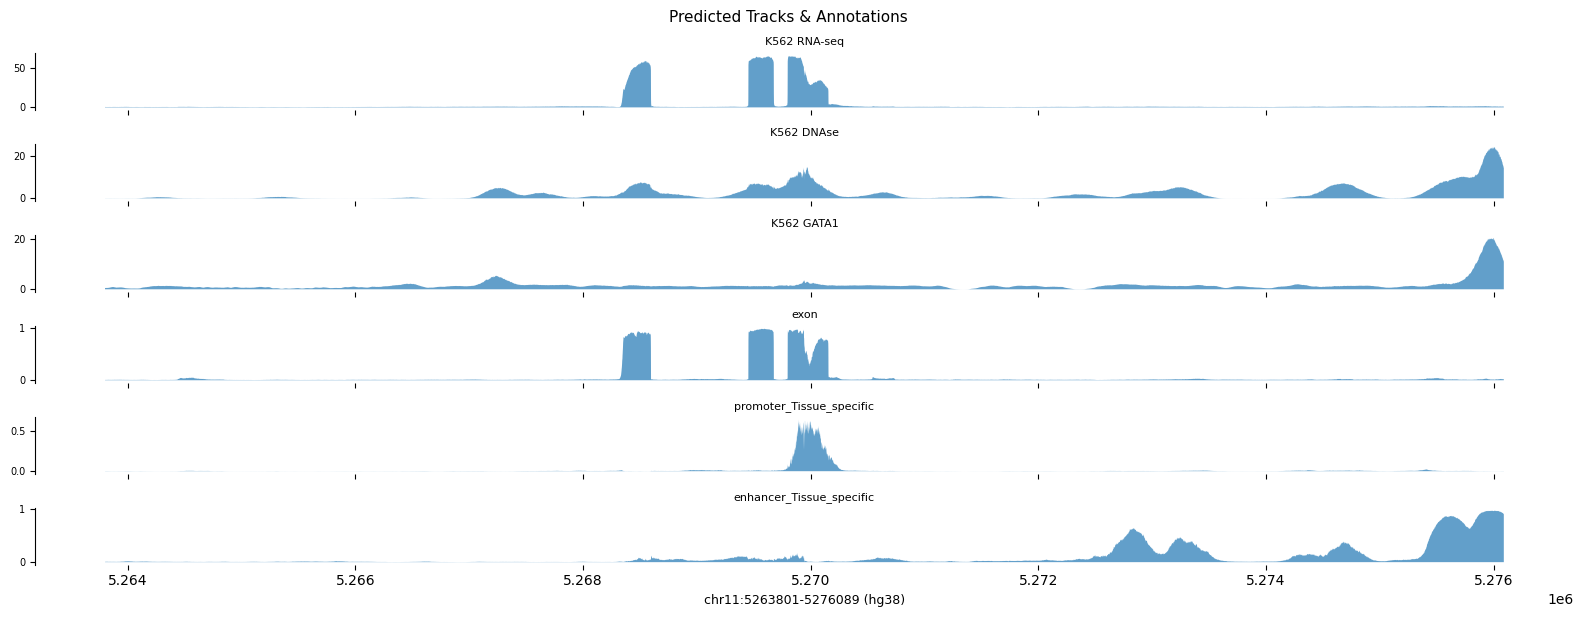


⏱️ Total time: 10.02 seconds


In [ ]:
# Define tracks and elements to visualize
tracks_to_plot = {
    "K562 RNA-seq": "ENCSR056HPM",
    "K562 DNAse": "ENCSR921NMD",
    "K562 GATA1": "ENCSR000EFT",
}
elements_to_plot = [
    "exon",
    "promoter_Tissue_specific",
    "enhancer_Tissue_specific",
]

# Run pipeline with all modalities
start_time = time.time()

result = ntv3_interpret(
    {"chrom": chrom, "start": start, "end": end, "species": species},
    output_attention=True,
    output_saliency=True,
    saliency_track_id=saliency_track_id,
    saliency_window_bp=1024,
    saliency_sequence_fraction=0.5,  # Use center 50% of sequence (default is 1.0 = 100%)
    plot=True,
    tracks_to_plot=tracks_to_plot,
    elements_to_plot=elements_to_plot,
)

elapsed = time.time() - start_time
print(f"\n⏱️ Total time: {elapsed:.2f} seconds")


## 4) 📊 Inspect Results


In [ ]:
# Print output shapes
print("Output shapes:")
print(f"  BigWig tracks: {result.bigwig_tracks_logits.shape}")
print(f"  BED elements:  {result.bed_tracks_logits.shape}")
print(f"  Attention:     {result.attention_maps.shape}")
print(f"  Saliency:      {result.saliency_scores.shape}")

# Print metadata
print(f"\nMetadata:")
print(f"  Region: {result.chrom}:{result.start:,}-{result.end:,}")
print(f"  Prediction region: {result.pred_start:,}-{result.pred_end:,}")
print(f"  Species: {result.species} ({result.assembly})")
print(f"  Saliency track: {result.saliency_track_id}")


Output shapes:
  BigWig tracks: (12288, 7362)
  BED elements:  (12288, 21, 2)
  Attention:     (12, 24, 256, 256)
  Saliency:      (16384, 11)

Metadata:
  Region: chr11:5,253,561-5,286,329
  Prediction region: 5,263,801-5,276,089
  Species: human (hg38)
  Saliency track: ENCSR000EFT


## 5) 🔗 Access Attention Profiles


In [ ]:
# Get attention profile to center (using helper method)
attn_profile = result.get_attention_to_center(layer_index=-1)
print(f"Attention profile shape: {attn_profile.shape}")

# Access raw attention for custom analysis
# result.attention_maps has shape (layers, heads, seq, seq)
n_layers, n_heads, seq_len, _ = result.attention_maps.shape
print(f"Full attention: {n_layers} layers, {n_heads} heads, {seq_len} tokens")


Attention profile shape: (256,)
Full attention: 12 layers, 24 heads, 256 tokens


### 🔺 Pyramid-Style Attention Map

Visualize attention as a triangular heatmap showing long-range interactions.


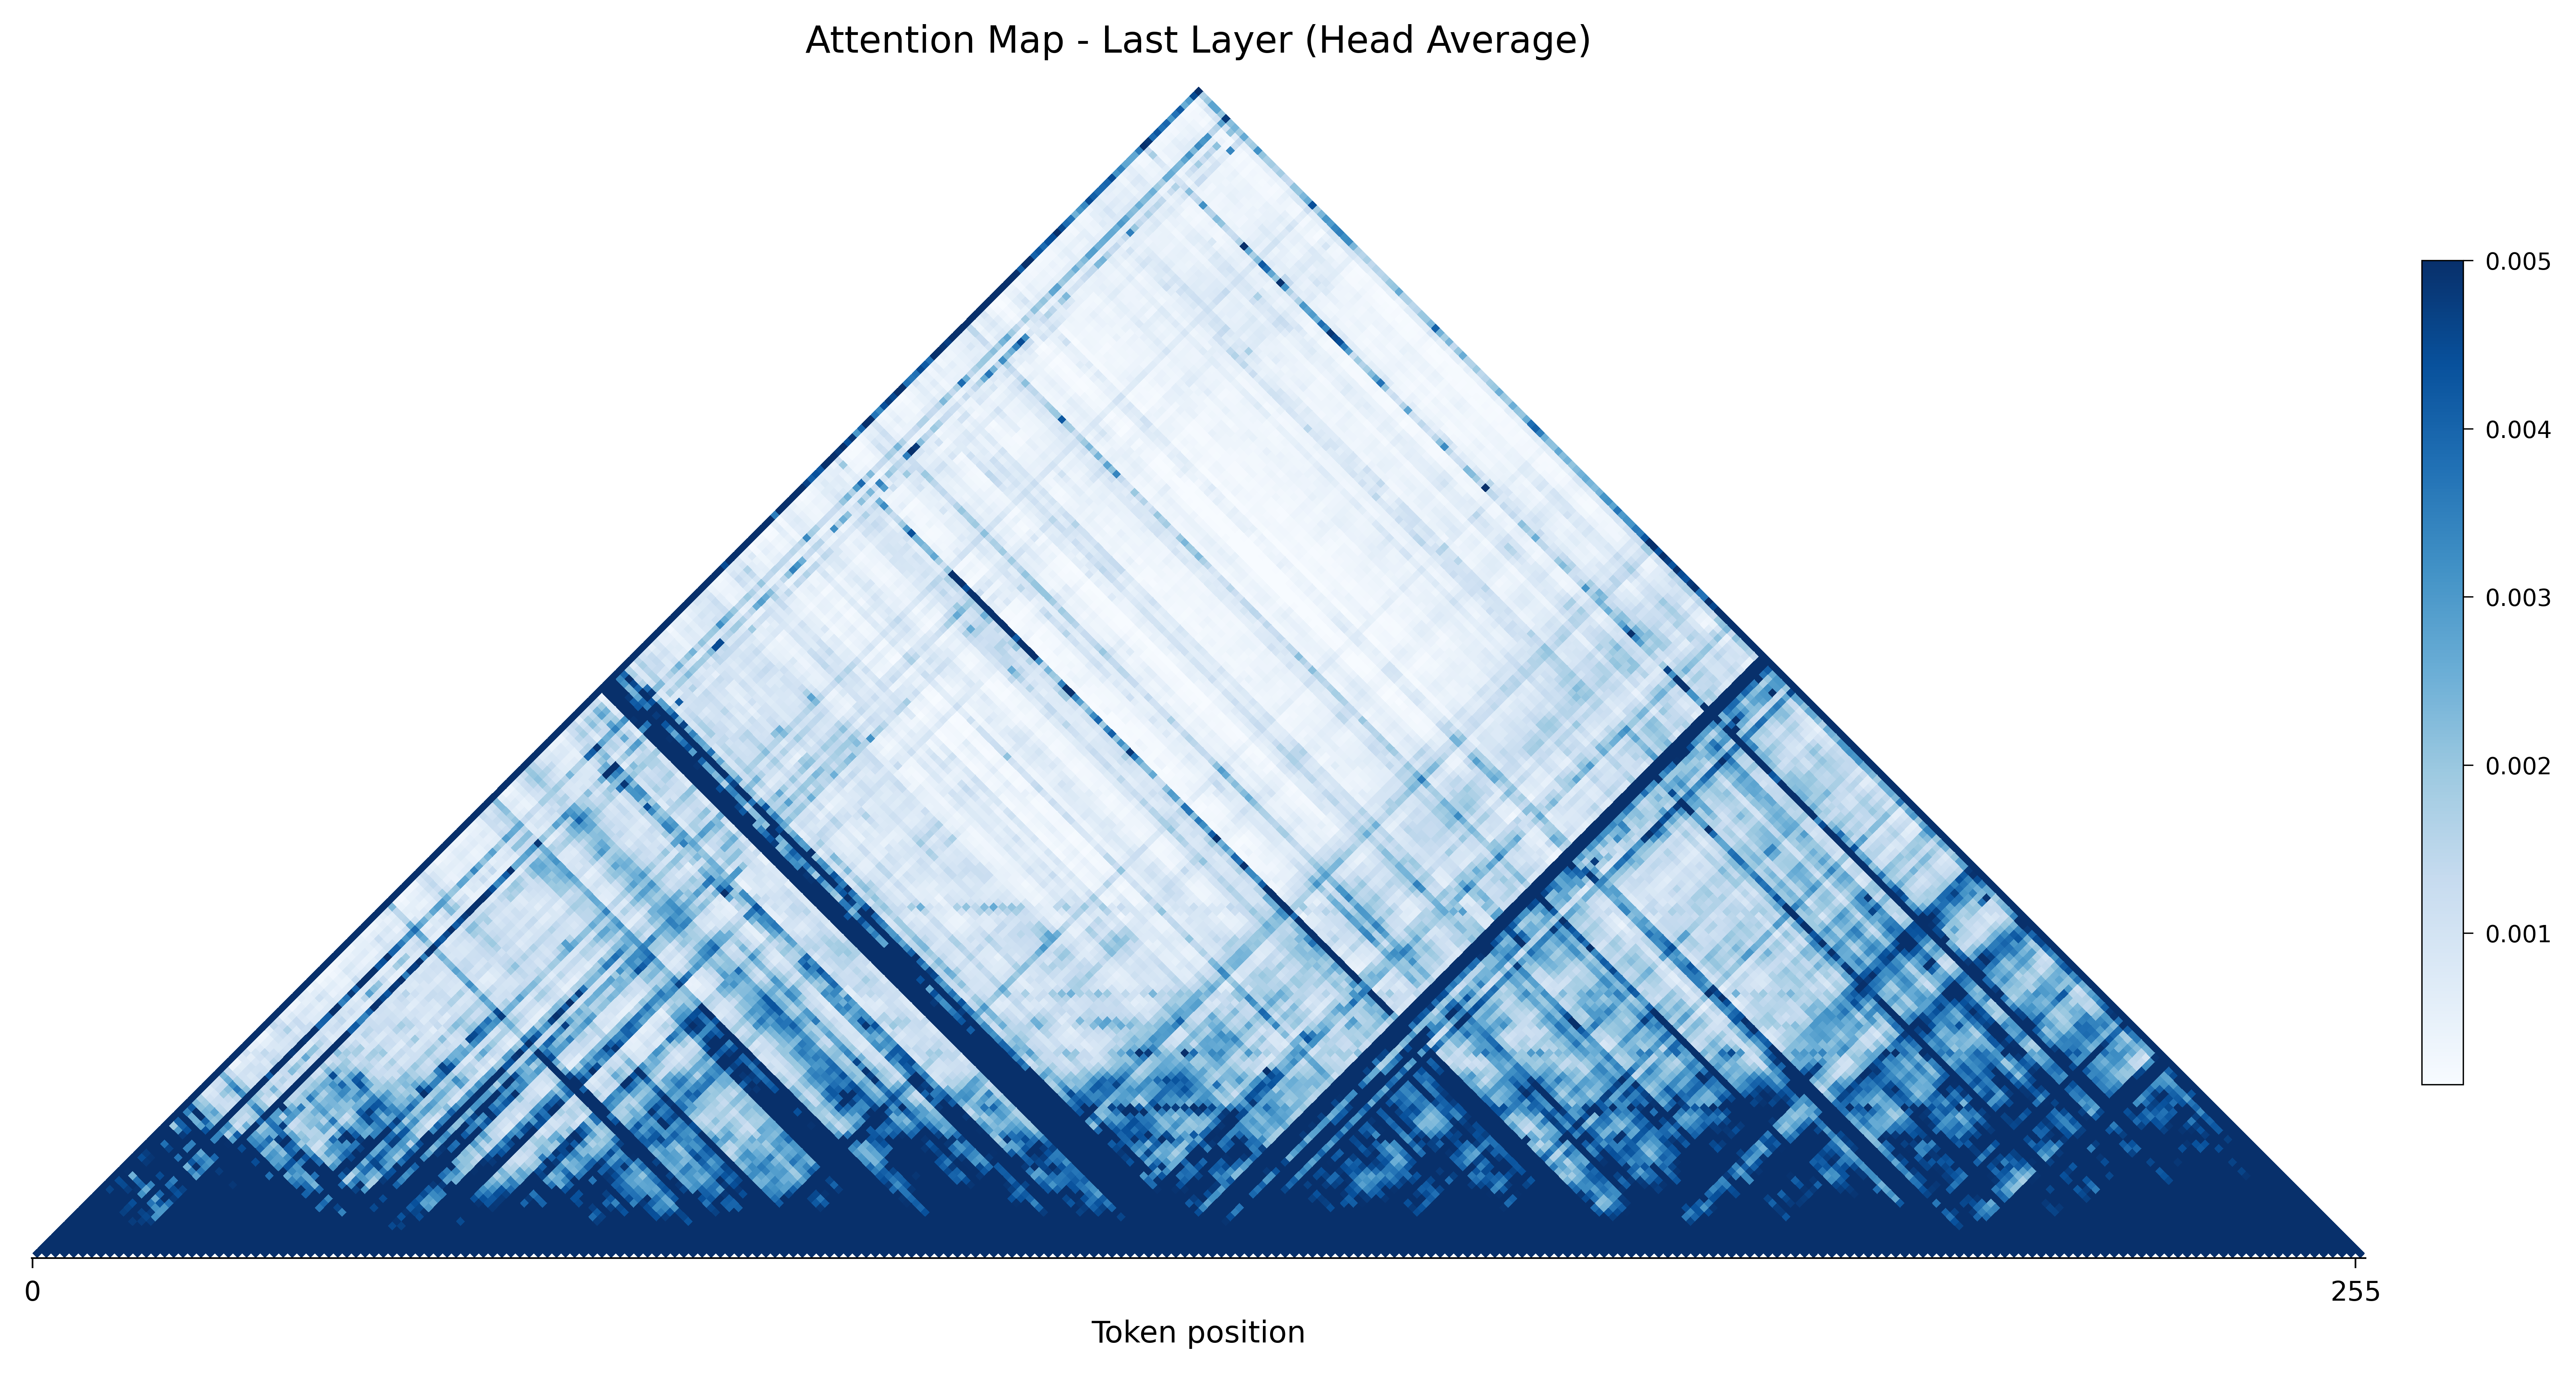

✅ Pyramid attention map plotted


In [ ]:
# --- Plot pyramid attention map ---

result.plot_attention() # attention map (last layer)
plt.show()
print("✅ Pyramid attention map plotted")

## 6) 🎯 Access Saliency Maps


In [ ]:
# Get saliency magnitude profile
saliency_profile = result.get_saliency_profile()
print(f"Saliency profile shape: {saliency_profile.shape}")

# # Get nucleotide-level saliency (A, T, C, G channels)
saliency_acgt = result.get_saliency_nucleotide(contribution_mode=True)
print(f"Nucleotide saliency shape: {saliency_acgt.shape}")

# Access raw gradients
print(f"Raw saliency shape: {result.saliency_scores.shape}")
print(f"One-hot sequence shape: {result.one_hot_sequence.shape}")

Saliency profile shape: (16384,)
Nucleotide saliency shape: (16384, 4)
Raw saliency shape: (16384, 11)
One-hot sequence shape: (16384, 11)


## 7) 🖼️ Visualization: Saliency Logo


Processing logos: 100%|██████████| 1/1 [00:00<00:00, 21.32it/s]


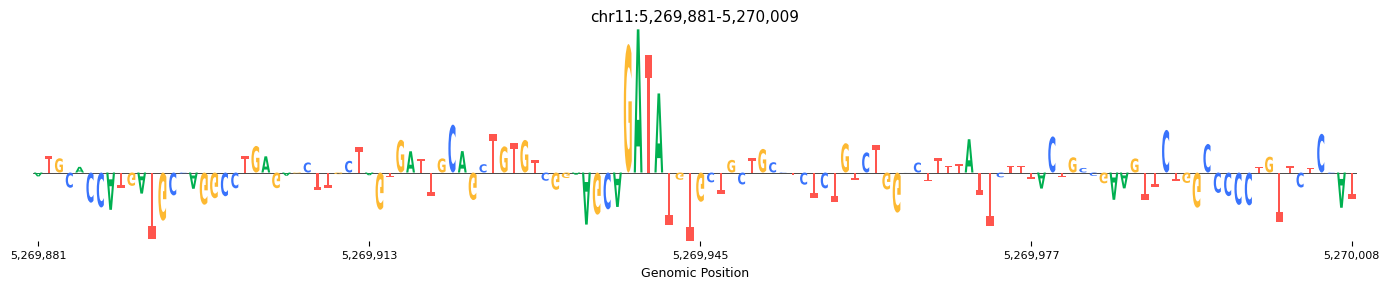

✅ Saliency logo plotted


In [ ]:
result.plot_saliency(window_size=128)       # Saliency logo (center 64bp)
plt.show()

print("✅ Saliency logo plotted")


## 8) 💾 Save Attributions to BigWig

Export saliency maps to BigWig format for visualization in genome browsers (e.g., IGV, UCSC Genome Browser).

In [ ]:
import os
import pyBigWig

# Create output directory
output_dir = "attribution_outputs"
os.makedirs(output_dir, exist_ok=True)

# Get saliency data with contribution_mode=True
saliency_contribution = result.get_saliency_nucleotide(contribution_mode=True)

# Sum across nucleotide channels to get single value per position
saliency_wt = saliency_contribution.sum(axis=1).astype(np.float32)

# Calculate genomic coordinates (accounting for saliency region offset)
saliency_offset = result.saliency_start_bp if result.saliency_start_bp else 0
saliency_start = result.start + saliency_offset
saliency_end = saliency_start + len(saliency_wt)

print(f"Saliency region: {result.chrom}:{saliency_start:,}-{saliency_end:,}")
print(f"Saliency length: {len(saliency_wt):,} positions")
print(f"Track used for attribution: {result.saliency_track_id}")

# --- Save wildtype contribution profile ---
output_filename = os.path.join(
    output_dir, f"saliency_{result.saliency_track_id}.bw"
)

bw = pyBigWig.open(output_filename, "w")
bw.addHeader([(result.chrom, saliency_end + 1000)])  # Add buffer for chrom size

# Add entries
starts = np.arange(saliency_start, saliency_start + len(saliency_wt), dtype=np.int64)
ends = starts + 1

bw.addEntries(
    chroms=[result.chrom] * len(starts),
    starts=starts.tolist(),
    ends=ends.tolist(),
    values=saliency_wt.tolist()
)

bw.close()

print(f"\n✅ Saved saliency BigWig: {output_filename}")
print(f"   This file contains the attribution score for the wildtype nucleotide")
print(f"   at each position (gradient × one-hot encoding).")

Saliency region: chr11:5,261,753-5,278,137
Saliency length: 16,384 positions
Track used for attribution: ENCSR000EFT

✅ Saved saliency BigWig: attribution_outputs/saliency_ENCSR000EFT.bw
   This file contains the attribution score for the wildtype nucleotide
   at each position (gradient × one-hot encoding).


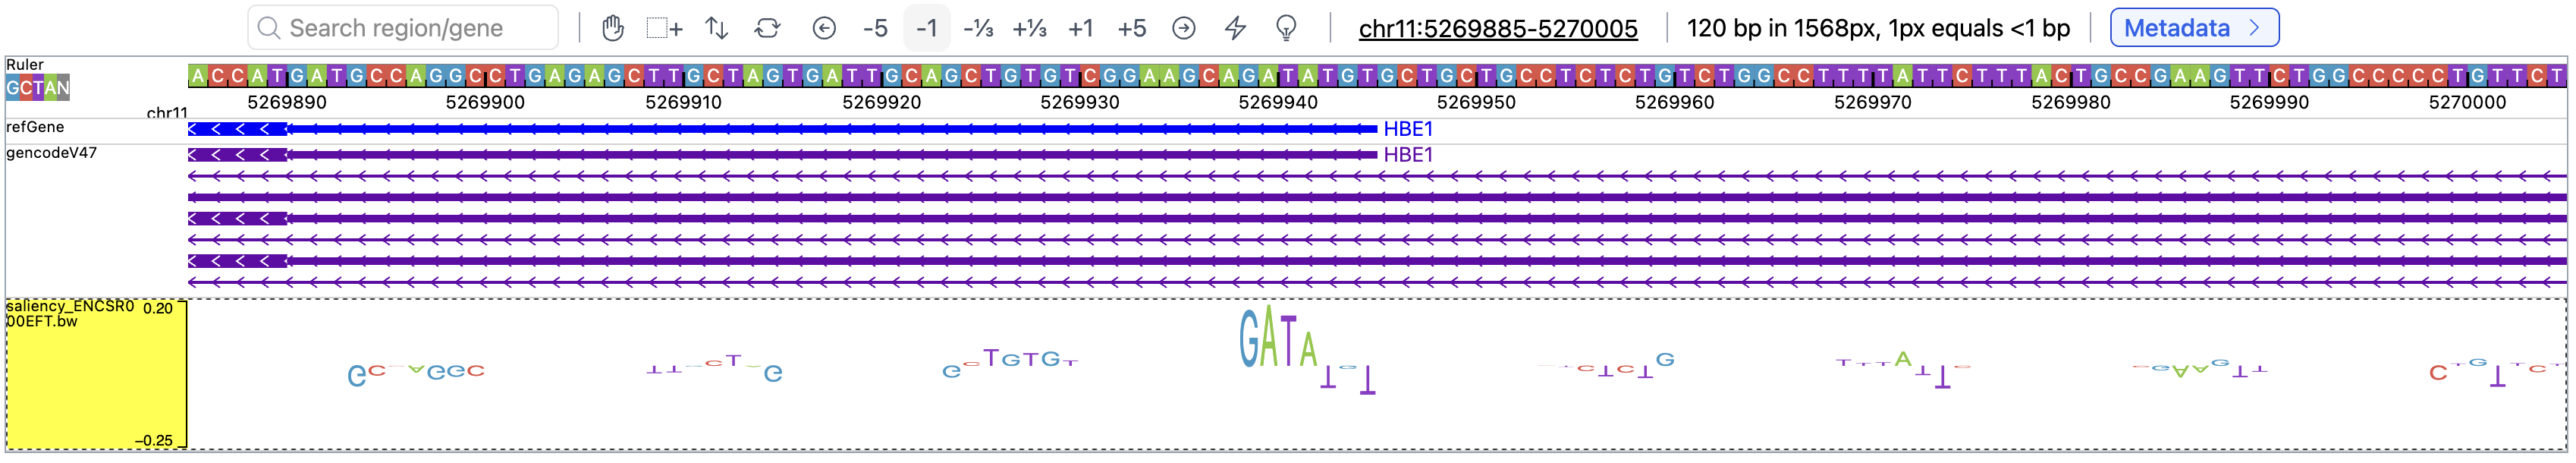

## 📝 Summary

This notebook demonstrated the NTv3 interpretation pipeline:

| Modality | Pipeline Arg | Output Access |
|----------|--------------|---------------|
| **Tracks** | (always) | `result.bigwig_tracks_logits` |
| **Annotations** | (always) | `result.bed_tracks_logits` |
| **Attention** | `output_attention=True` | `result.attention_maps`, `result.get_attention_to_center()` |
| **Saliency** | `output_saliency=True` | `result.saliency_scores`, `result.get_saliency_profile()` |

### 💾 BigWig Export

Saliency maps can be exported to BigWig format for visualization in genome browsers:

| File | Description |
|------|-------------|
| `saliency_{track_id}.bw` | Attribution score for the wildtype nucleotide at each position |

The file contains the **contribution score** (gradient × one-hot encoding) which shows how much the actual nucleotide at each position influences the model's prediction for the selected track.

### 💡 Key Features

- ✅ **Single pipeline call** for all interpretation modalities
- ✅ **Built-in visualization** with `plot=True`
- ✅ **Helper methods** for common analysis patterns
- ✅ **Raw access** for custom analysis
- ✅ **BigWig export** for genome browser visualization

### 📚 Additional Resources

- Step-by-step tutorial: [`03_model_interpretation.ipynb`](https://huggingface.co/spaces/InstaDeepAI/ntv3/blob/main/notebooks_tutorials/03_model_interpretation.ipynb)
- Track prediction pipeline: [`01_functional_track_prediction.ipynb`](https://huggingface.co/spaces/InstaDeepAI/ntv3/blob/main/notebooks_pipelines/01_functional_track_prediction.ipynb)
- Track prediction tutorial: [`01_tracks_prediction.ipynb`](https://huggingface.co/spaces/InstaDeepAI/ntv3/blob/main/notebooks_tutorials/01_tracks_prediction.ipynb)
